# Train and test of the model

#### Importamos librerias

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#### Cargamos los datos

In [51]:
all_seasons_data = pd.read_csv('all_seasons_no_outliers.csv')

In [52]:
all_seasons_data = all_seasons_data.drop(columns = 'position')

Vamos a calcular metricas que nos muestren la evaluación de los jugadores en las últimas 3,5,10 jornadas

In [53]:
num_matchweeks = [3,5,10]

grouped = all_seasons_data.sort_values(['Temporada', 'Jornada']).groupby('playerId')

rolling_avg_columns = ['mins', 'g', 'ga', 'oaa', 'pae', 'br', 'tsa', 'wc', 'pla']

rolling_avgs = []
for num_matchweeks in [3, 5, 10]:
    rolling_avg = grouped.rolling(window=num_matchweeks, min_periods=1).mean().reset_index(level=0, drop=True)
    rolling_avg = rolling_avg[rolling_avg_columns]
    rolling_avg.columns = [f'avg_{col}_last{num_matchweeks}w' for col in rolling_avg_columns]
    rolling_avgs.append(rolling_avg)

rolling_avg_all = pd.concat(rolling_avgs, axis=1)


efficiency_metrics = filtered_data.copy()
efficiency_metrics['goals_per_min'] = efficiency_metrics['g'] / efficiency_metrics['mins'].replace(0, 1)
efficiency_metrics['assists_per_min'] = efficiency_metrics['ga'] / efficiency_metrics['mins'].replace(0, 1)
efficiency_metrics['recoveries_per_game'] = efficiency_metrics['br'] / efficiency_metrics['mins'].replace(0, 1) * 90

enhanced_data = pd.concat([all_seasons_data, rolling_avg_all, efficiency_metrics[['goals_per_min', 'assists_per_min', 'recoveries_per_game']]], axis=1)

enhanced_data.head()


,playerId,tid,tp,mins,g,ga,oaa,pae,pw,ps,...,avg_ga_last10w,avg_oaa_last10w,avg_pae_last10w,avg_br_last10w,avg_tsa_last10w,avg_wc_last10w,avg_pla_last10w,goals_per_min,assists_per_min,recoveries_per_game
0,81,3,12,70,1,0,0,0,0,0,...,0.000000,0.000000,0.200000,3.300000,0.600000,0.900000,7.700000,0.014286,0.000000,6.428571
1,576,21,12,72,1,1,0,3,0,0,...,0.222222,0.111111,1.888889,2.777778,0.555556,1.444444,10.888889,0.013889,0.013889,2.500000
2,327,19,12,77,1,1,0,0,0,0,...,0.200000,0.000000,0.400000,3.700000,0.100000,0.300000,5.800000,0.012987,0.012987,1.168831
3,927,3,11,70,1,0,1,0,0,0,...,0.142857,0.142857,1.428571,1.857143,0.714286,1.000000,11.142857,0.014286,0.000000,2.571429
4,228,11,11,74,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,5.555556,0.333333,0.555556,6.000000,0.013514,0.000000,8.513514


Vamos a guardar los datos en un archivo llamado enhanced

In [54]:
enhanced_data.to_csv('enhanced_data.csv', index=False)

In [55]:
enhanced_data.drop(columns='avg',inplace=True)

Se van a dividir los datos en 2 conjuntos: 
* Train: tomará el 80% de los datos
* Test: tomará el 20% de los datos acorde a test_size=0.2
* random_state será la semilla aleatoria se utilizará para la división

In [57]:
features = enhanced_data.drop(columns=['tp', 'Temporada', 'Jornada'])
target = enhanced_data['tp']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


### Training models

#### Random Forest Regressor

In [66]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

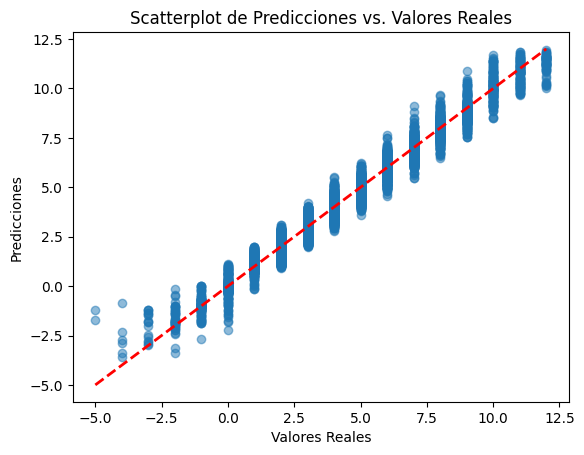

In [72]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Scatterplot de Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.savefig('./figures/scatter_random_forest.png')
plt.show()

In [59]:
rf_regressor = RandomForestRegressor(random_state=42)


cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='r2')

rf_regressor.fit(X_train, y_train)

feature_importances = rf_regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Puntuaciones de validación cruzada (R2):", cv_scores)
print("Media de las puntuaciones de validación cruzada:", np.mean(cv_scores))
print("Importancia de las características:")
print(importance_df.head(15))

Puntuaciones de validación cruzada (R2): [0.98382053 0.98400861 0.98326657 0.98434945 0.98271751]
Media de las puntuaciones de validación cruzada: 0.9836325342980785
Importancia de las características:
                Feature  Importance
22                   ip    0.974622
2                  mins    0.003563
12                   gc    0.003127
0              playerId    0.002372
15                   rc    0.001110
19                  pla    0.000878
20                   pc    0.000804
1                   tid    0.000751
49      avg_pla_last10w    0.000731
46       avg_br_last10w    0.000671
41     avg_mins_last10w    0.000656
52  recoveries_per_game    0.000655
40       avg_pla_last5w    0.000607
31       avg_pla_last3w    0.000606
28        avg_br_last3w    0.000548


#### Regresión lineal

In [70]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

#### Visualización regresión

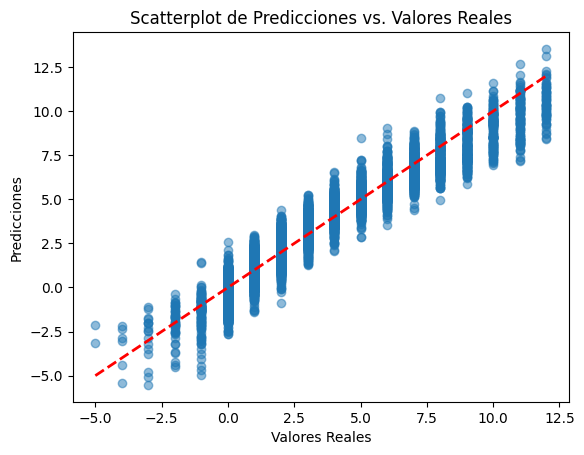

In [71]:
plt.scatter(y_test, lr_predictions, alpha=0.5)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Scatterplot de Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.savefig('./figures/scatter_linear_regression.png')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de identidad
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs. Valores Predichos - Árbol aleatorio')
plt.show()

### Model evaluation

In [73]:
print("Linear Regression: MSE =", lr_mse, "R2 =", lr_r2)
print("Random Forest: MSE =", mse, "R2 =", r2)

Linear Regression: MSE = 0.6392185946088884 R2 = 0.9286585694548309
Random Forest: MSE = 0.14359144173798552 R2 = 0.9839741538277699


In [ ]:

from sklearn.metrics import mean_squared_error, r2_score

### Make the prediction data

In [26]:
latest_data = enhanced_data[(enhanced_data['Temporada'] == latest_season) & 
                            (enhanced_data['Jornada'] == last_matchweek)]
latest_data

,playerId,tid,tp,mins,g,ga,oaa,pae,pw,ps,...,avg_ga_last10w,avg_oaa_last10w,avg_pae_last10w,avg_br_last10w,avg_tsa_last10w,avg_wc_last10w,avg_pla_last10w,goals_per_min,assists_per_min,recoveries_per_game
47937,344,20,12,22,1,0,0,1,0,0,...,0.0,0.2,1.0,1.6,0.2,0.3,8.1,0.045455,0.000000,8.181818
47938,246,15,12,90,0,1,1,1,0,0,...,0.4,0.4,1.5,5.2,0.4,0.1,8.5,0.000000,0.011111,6.000000
47939,310,20,12,90,1,0,0,3,0,0,...,0.1,0.0,0.8,6.6,0.3,0.7,9.0,0.011111,0.000000,4.000000
47940,1329,9,12,90,2,0,0,0,0,0,...,0.1,0.2,0.4,2.5,1.3,0.7,10.6,0.022222,0.000000,4.000000
47941,1719,3,12,24,1,0,0,0,0,0,...,0.0,0.0,0.0,0.3,0.3,0.3,1.0,0.041667,0.000000,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48451,1345,9,-1,89,0,0,0,0,0,0,...,0.0,0.0,0.0,6.9,0.0,0.1,10.6,0.000000,0.000000,3.033708
48452,1491,2,-1,9,0,0,0,0,0,0,...,0.1,0.2,0.2,3.1,0.2,0.4,10.3,0.000000,0.000000,0.000000
48453,1650,10,-1,90,0,0,0,0,0,0,...,0.0,0.0,0.4,2.7,0.1,0.4,10.2,0.000000,0.000000,4.000000
48454,1253,1,-2,64,0,0,0,0,0,0,...,0.0,0.0,0.5,4.0,0.1,0.0,10.4,0.000000,0.000000,4.218750


In [ ]:

def update_rolling_features(df, weeks=1):
    """
    Update the rolling features for future weeks.
    We assume the most recent performance will continue for simplicity.
    """
    for week in range(weeks):
        for col in df.columns:
            if 'last' in col:
                # Extract the number of weeks from the column name
                num_weeks = int(col.split('last')[1].split('w')[0])
                # Update the rolling feature by reducing the window
                new_col = col.replace(f'last{num_weeks}w', f'last{num_weeks+1}w')
                if new_col in df.columns:
                    df[col] = df[new_col]
    return df

# Prepare datasets for the next 4 weeks
weeks_to_forecast = 4
forecast_datasets = {}

for i in range(1, weeks_to_forecast + 1):
    # Update the rolling features
    updated_data = update_rolling_features(prediction_features.copy(), weeks=i)
    

In [ ]:
latest_season = enhanced_data['Temporada'].max()
last_matchweek = enhanced_data[enhanced_data['Temporada'] == latest_season]['Jornada'].max()

latest_season, last_matchweek